In [71]:
%matplotlib inline

In [79]:
import os
import shutil
import random
import time
import math
import cv2
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from utils import show_image

In [80]:
CWD = '/'.join(os.getcwd().replace('\\', '/').split('/')[:-1])
CWD

'E:/Cloud/GIT/CVEET'

In [75]:
def getImagesOfInterest(path):
    """Return a list of images + their respective xml bbox+labels file."""
    files = []
    for filename in os.listdir('../images/raw/'):
        f = '{}/images/raw/{}.xml'.format(CWD, filename[:-4]) # Target file for obj. and bboxes.
        if (not filename.endswith(".jpg")) or (not os.path.isfile(f)):
            continue
        files.append(filename[:-4])
    return files

Move raw images plus their respective xml/json bounding box + object files to train / test / valid

In [76]:
def createTrainTestData(perc=0.8, path='../images/raw/'):
    files = getImagesOfInterest(path)
    random.shuffle(files)
    items = int(len(files)*perc)
    train = files[:items]
    test = files[items:]
    print(len(files), '--->', len(train), len(test))
    
    for f in train:
        shutil.copyfile('../images/raw/{}.jpg'.format(f), '../images/train/{}.jpg'.format(f))
        shutil.copyfile('../images/raw/{}.xml'.format(f), '../images/train/{}.xml'.format(f))
        #break
    
    for f in test:
        shutil.copyfile('../images/raw/{}.jpg'.format(f), '../images/test/{}.jpg'.format(f))
        shutil.copyfile('../images/raw/{}.xml'.format(f), '../images/test/{}.xml'.format(f))
        #break
        
    print("Finished train-test split, using", perc, '% train and', 1-perc, 'test.')

In [77]:
createTrainTestData(0.9)

772 ---> 694 78
Finished train-test split, using 0.9 % train and 0.09999999999999998 test.


Crop and save regions from images, based on respective XML file.

In [7]:
def parseBBOXFile(file):
    with open(file, 'r') as f:
        content = []
        for i, line in enumerate(f):
            if i <= 12: # Skip these lines.
                continue
            line = line.strip().lower().replace('\n', '').replace('\r', '').replace('\t', '')
            line = line.replace('</object>', '')
            content.append(line)
        return ''.join(content[:-1]).split('<object>')[1:] # Return content - last line.
    
def getTagValue(text, tag):
    start, end = text.find('<{}>'.format(tag)), text.find('</{}>'.format(tag))
    return text[(start+len(tag)+2):end]

In [8]:
def createImagesFromBBOX(path='../images/raw/'):
    vehicles = {}
    for f in getImagesOfInterest(path):
        jpg, xml = '{}{}.jpg'.format(path, f), '{}{}.xml'.format(path, f)
        img = cv2.imread(jpg, cv2.IMREAD_COLOR)
        for obj in parseBBOXFile(xml):
            label = getTagValue(obj, 'name')
            vehicles[label] = vehicles.get(label, 0) + 1
            xmin = int(getTagValue(obj, 'xmin'))
            ymin = int(getTagValue(obj, 'ymin'))
            xmax = int(getTagValue(obj, 'xmax'))
            ymax = int(getTagValue(obj, 'ymax'))
            print(label, xmin, ymin, xmax, ymax)
            img_region = img[ymin:ymax, xmin:xmax].copy()
            show_image(img_region, size=(2,1))
            cv2.imwrite('../images/raw_classify/{}_{}.jpg'.format(label, vehicles[label]), img_region)
            
        break # Do this if we need to train a classifier.

car 486 295 509 315


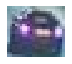

car 421 239 429 246


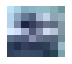

car 411 232 419 239


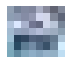

car 401 228 406 233


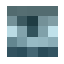

car 305 236 318 246


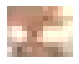

In [27]:
createImagesFromBBOX()

In [95]:
def getNumObjects(path='../images/raw/'):
    num = 0
    for f in getImagesOfInterest(path):
        num += len(parseBBOXFile('{}{}.xml'.format(path, f)))
    return num

def getNumObjectsOfType(path='../images/raw/'):
    types = defaultdict(int)
    for f in getImagesOfInterest(path):
        for obj in parseBBOXFile('{}{}.xml'.format(path, f)):
            label = getTagValue(obj, 'name')
            types[label] = (types[label] + 1)
    return types

In [85]:
getNumObjects()

5215

In [96]:
def scramble(path='../images/raw/'):
    """Move a selected grp of images, shuffle and copy X images over to temp."""
    files = []
    for filename in os.listdir('../images/raw/'):
        f = '{}/images/raw/{}.xml'.format(CWD, filename[:-4]) # Target file for obj. and bboxes.
        if (not filename.endswith(".jpg")) or (os.path.isfile(f)):
            continue
        if not (('_18-01' in filename) or ('_19-01' in filename)):
            continue
        files.append(filename[:-4])
        
    grps = {}
    for f in files:
        idx = f.find('_18-01')
        if idx == -1:
            idx = f.find('_19-01')
        if not (f[:idx] in grps):        
            grps[f[:idx]] = []
        grps[f[:idx]].append(f)
    
    files = []
    for k, v in grps.items():
        random.shuffle(v)
        random.shuffle(v)
        files += v[:10]
        
    print('Copying to temp:\n', files)
    for f in files:
        shutil.copyfile('../images/raw/{}.jpg'.format(f), '../images/temp/{}.jpg'.format(f))

In [97]:
#scramble()

In [100]:
def hist(d):
    """Plot Histogram of Gradient for a given bin vector."""
    X = []
    for i, v in enumerate(d.values()):
        X.extend((np.zeros(int(round(v)), dtype=np.uint64)+i).tolist())
    fig, ax = plt.subplots(1, figsize=(26,14), tight_layout=True)
    ax.hist(X, bins=np.arange(len(d)+1)-0.5, rwidth=0.35)
    ax.set_title('Vehicle Distribution', fontsize=24)
    ax.set_xlabel('Vehicle', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)
    ax.set_xticklabels(list(d.keys()))
    plt.xticks(np.arange(len(d)), fontsize=20)
    plt.yticks(fontsize=20)
    #plt.savefig('./fig/plot_bins.png', transparent=False, bbox_inches='tight')
    plt.show()

<ipython-input-100-188fd65fd25c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(d.keys()))


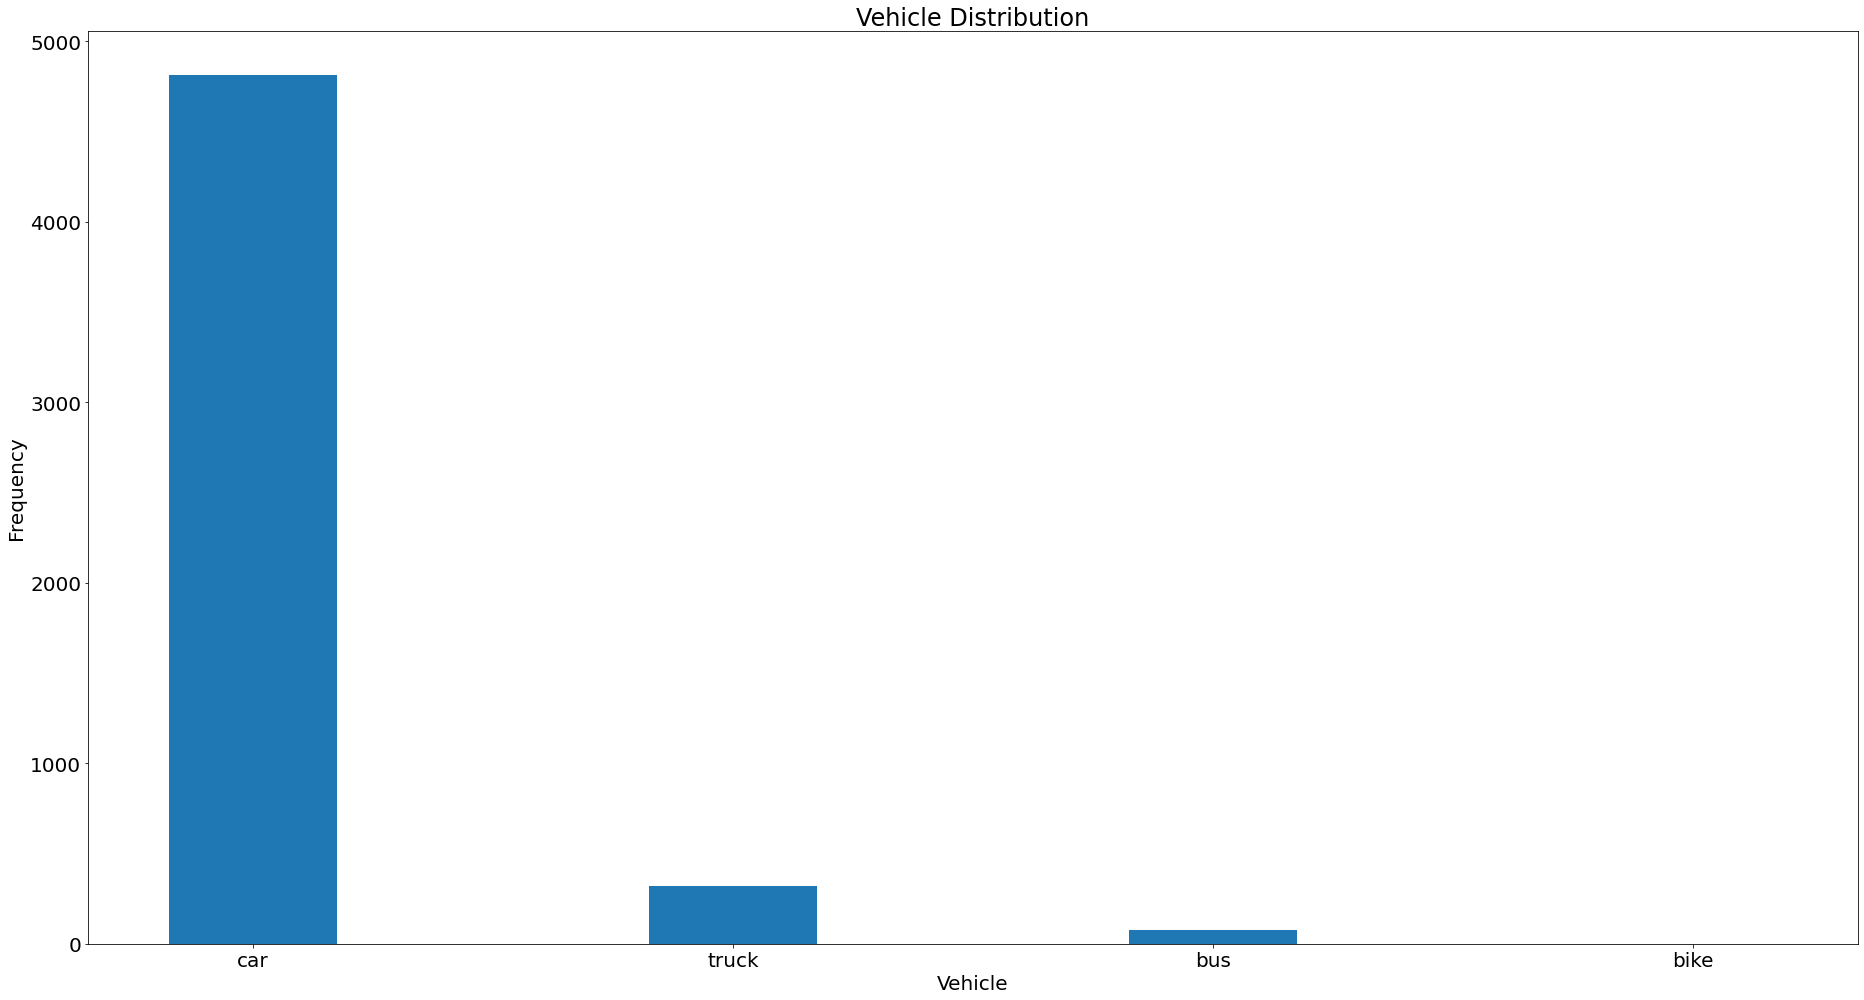

In [101]:
veh_typ = getNumObjectsOfType()
hist(veh_typ)

In [102]:
veh_typ

defaultdict(int, {'car': 4815, 'truck': 322, 'bus': 77, 'bike': 1})